In [11]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
from scipy.stats import zscore
%matplotlib inline

In [59]:
#####

# In this example, we will walk through a simple method to compare two statistical models for noise
# for Maximum Likelihood Estimation in generating linear regression models.

# 1) The normally distributed error 
# 2) T-distributed error

#We will use a toy dataset about nasal length vs. nasal width of kangaroos from here: 
#http://college.cengage.com/mathematics/brase/understandable_statistics/7e/students/datasets/slr/frames/frame.html
#####

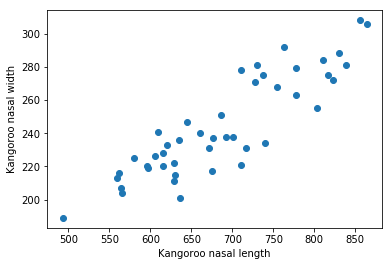

In [13]:
df = pd.read_csv('slr07.csv')
plt.scatter(df.X, df.Y);
plt.xlabel("Kangoroo nasal length")
plt.ylabel("Kangoroo nasal width");

In [58]:
df.shape

(45, 2)

We start with the first case - assuming normal iid for statistical model of noise to build the linear regression model. In other words, each $y_i$ is gaussian distributed with mean $\bf{w.x_{i}}$ and the variance $\bf{\sigma^{2}}$





The Beta 0 and Beta 1 for Linear Regression with 
normally distributed error
[ 46.45081363   0.28761237]
The R^2 of the Linear Regression (OLS Method) assuming 
normally distributed error
0.776891408938


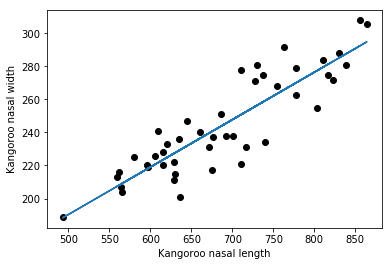

In [21]:
x = df['X']
y = df['Y']
from statsmodels.api import OLS

comparison_dict = {}
x_train = sm.add_constant(x.values)

model = sm.OLS(df['Y'].values,x_train)

fitted_model =model.fit()
r2= r2_score(df['Y'],fitted_model.predict())

print("The Beta 0 and Beta 1 for Linear Regression with \nnormally distributed error")
print(fitted_model.params)
comparison_dict['Normal Error'] = [fitted_model.params[0],fitted_model.params[1],(r2)]
print("The R^2 of the Linear Regression (OLS Method) assuming \nnormally distributed error")
print(r2)
plt.plot(x,y,'ko',x,fitted_model.predict());

plt.xlabel("Kangoroo nasal length")
plt.ylabel("Kangoroo nasal width");

Now, we need to solve for MLE coefficients fot the Student t-distribution using a numerical method. We use Truncated Newton Method, 'tnc', to minimize the negative log likelihood of the distribution.

     fun: 534.03472219685375
     jac: array([ 0.05968559, -0.00255795])
 message: 'Max. number of function evaluations reached'
    nfev: 100
     nit: 26
  status: 3
 success: False
       x: array([ 54.37252659,   0.28284086])
The Beta 0 and Beta 1 for Linear Regression with t-student distributed error
54.3725265878 0.282840857813
The R^2 of the Linear Regression assuming t-distributed error
0.752556372797


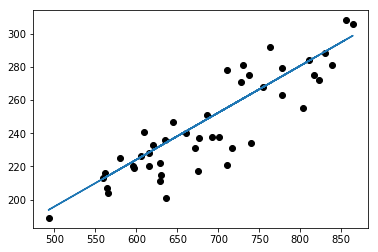

In [22]:
from scipy.optimize import minimize
from scipy.special import gamma
import numpy as np

y=np.array(df['Y'].values)
x=np.array((df['X']).values)

#initial beta guess
beta = np.array([[1],[1]])
nu = 5
theta = 0.5
x_train =sm.add_constant(x)

#likelihood function
def student_likelihood(y,ypred):
    res = y - ypred
    return sum(np.log((gamma((nu+1)/2)/(gamma(nu/2)*np.sqrt(np.pi*nu)*theta))*((1+(1/nu)*((res*res)/(theta**2)))**(-(nu+1)/2))))
    
#wrapper for minimizing beta 
def pdf_to_minimize(beta):
    ypred = np.dot(x_train,beta)
    return -1*(student_likelihood(y,ypred))

#minimazing algorithm
log_norm = minimize(fun=pdf_to_minimize,x0=beta, method='tnc', options={'maxiter': 100})

print(log_norm)
beta = log_norm.x
beta0 = beta[0]
beta1 = beta[1]


ypred = np.dot(x_train,beta)

r2_t = r2_score(y,ypred)
print("The Beta 0 and Beta 1 for Linear Regression with t-student distributed error")
print(beta0,beta1)
print("The R^2 of the Linear Regression assuming t-distributed error")
print(r2_t)

comparison_dict['T-error'] = [beta0,beta1,r2_t]
plt.plot(x,y,'ko',x,ypred);

In [57]:
df2 = pd.DataFrame(data=comparison_dict)
params = pd.DataFrame(data={'parameter':['Beta 0','Beta 1', 'R^2']})
result = pd.concat([params,df2],axis=1)
result

,parameter,Normal Error,T-error
0,Beta 0,46.450814,54.372527
1,Beta 1,0.287612,0.282841
2,R^2,0.776891,0.752556


**When we model our errors using the t-distribution when estimating the Maximum Likelihood Coefficients, we get a slightly worse R^2 (0.75 vs. 0.78) in this case.**

In general, though, it may be good to consider the t-distribution for modelling errors in certain situations. 

If the question concerns the entire population as it is distributed, then the normal distribution should be used. 

If the question concerns the mean of the population then the t-statistic may be used (The t-distribution takes some weight off the distribution tails and puts the weight in the middle). 

For the use of either, a larger sample size gives a better result. In certain cases with a small number of data points, the t-distribution may work better as well.

For more background reading, Evans, Hastings, and Peacock's book "Statistical Distributions" might be helpful!